In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.spea2 import SPEA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize
import matplotlib.pyplot as plt
from pymoo.visualization.scatter import Scatter

# Step 1: Load and Preprocess Data
data = pd.read_excel("dataset/data.xlsx")  # Load dataset

# Define input and output columns
soil_params = ["N", "P", "K", "S", "Zn", "Cu", "Fe", "Mn", "B"]  # Inputs
crop_yields = ["BajraY", "WheatY", "MustardY", "BarleyY", "MoongY", "GuarY"]  # Outputs

# Split into features (X) and target (y)
X_soil = data[soil_params]
y = data[crop_yields]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_soil, y, test_size=0.2, random_state=42)

# Step 2: Train Yield Prediction Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train.values, y_train.values)

def predict_yields(soil_input):
    return rf_model.predict([soil_input])[0]

# Step 3: Define Selling Prices, Costs, and Demand Factors with Season Classification
crop_prices = {'BajraY': 26.25, 'WheatY': 24.25, 'MustardY': 59.50, 'BarleyY': 19.80, 'GuarY': 48.40, 'MoongY': 86.82}
max_price = max(crop_prices.values())

# Define which crops belong to which season
rabi_crops = ['WheatY', 'MustardY', 'BarleyY']  # Winter crops
kharif_crops = ['BajraY', 'GuarY', 'MoongY']    # Summer crops

crop_data = {}
for crop in crop_yields:
    price = crop_prices[crop]
    if 'Bajra' in crop:
        cp = 16.84
        water = 525
    elif 'Wheat' in crop:
        cp = 11.82
        water = 550
    elif 'Mustard' in crop:
        cp = 30.11
        water = 375
    elif 'Barley' in crop:
        cp = 12.39
        water = 300
    elif 'Guar' in crop:
        cp = 42.0  
        water = 300
    elif 'Moong' in crop:
        cp = 51.59
        water = 400
    else:
        cp = 0.0
        water = 0
        
    crop_data[crop] = {
        'SP': price,
        'CP': cp,
        'W': water,
        'D': price / max_price,
        'season': 'rabi' if crop in rabi_crops else 'kharif'
    }
rabi_mask = np.array([1 if crop_data[crop]['season'] == 'rabi' else 0 for crop in crop_yields])
kharif_mask = 1 - rabi_mask


In [ ]:
import numpy as np
from pymoo.algorithms.moo.spea2 import SPEA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.operators.sampling.lhs import LHS

class CropProblemSPEA2(Problem):
    def __init__(self):
        super().__init__(n_var=6, n_obj=3, n_eq_constr=2, xl=0.0, xu=1.0)
        self.y_pred = rf_model.predict(X_soil.mean().values.reshape(1, -1))[0]
        self.obj_scaling = np.array([1e-5, 1e-4, 1e-3])
        
    def _evaluate(self, x, out, *args, **kwargs):
        n_pop = x.shape[0]
        f = np.zeros((n_pop, 3))
        h = np.zeros((n_pop, 2))  # Equality constraints
        
        for i in range(n_pop):
            # Calculate sums for Rabi and Kharif allocations
            sum_rabi = np.sum(x[i] * rabi_mask)
            sum_kharif = np.sum(x[i] * kharif_mask)
            
            # Calculate objectives (no normalization needed now)
            profit = np.sum([x[i][j] * (crop_data[crop]['SP'] * self.y_pred[j] - crop_data[crop]['CP']) for j, crop in enumerate(crop_yields)])
            yield_ = np.sum(x[i] * self.y_pred)
            water = np.sum([x[i][j] * crop_data[crop]['W'] for j, crop in enumerate(crop_yields)])
            f[i] = [-profit * self.obj_scaling[0],-yield_ * self.obj_scaling[1],water * self.obj_scaling[2]]
            h[i] = [(sum_rabi - 1) - 1e-4, (sum_kharif - 1) - 1e-4]  # Must equal 0
        
        out["F"] = f
        out["H"] = h  


In [3]:
# Initialize and run SPEA2
algorithm = SPEA2(
    pop_size=100,
    sampling=LHS(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=25),
    eliminate_duplicates=True,
    save_history=True,
)

problem = CropProblemSPEA2()
termination = get_termination("n_gen", 100)
res_spea2 = minimize(problem, algorithm, termination, seed=42, verbose=True)


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  0.0458458863 |  1.1766011598 |             - |             -
     2 |      200 |      1 |  0.0458458863 |  0.5330091300 |             - |             -
     3 |      300 |      1 |  0.0402456688 |  0.3047262529 |             - |             -
     4 |      400 |      1 |  0.0355299775 |  0.1967032547 |             - |             -
     5 |      500 |      1 |  0.0355299775 |  0.1395324232 |             - |             -
     6 |      600 |      1 |  0.0170282015 |  0.1052224160 |             - |             -
     7 |      700 |      1 |  0.0145771705 |  0.0788583128 |             - |             -
     8 |      800 |      1 |  0.0119203028 |  0.0608834315 |             - |             -
     9 |      900 |      1 |  0.0093471510 |  0.0458713422 |             - |             -
    10 |     1000 |      1 |  0.0093471510 |  0.0399304195 |             - |             -

c:\Users\Sachit Vij\OneDrive\Documents\Crop_Diversification\Crop_fertility\myenv\Lib\site-packages\pymoo\algorithms\moo\spea2.py:62: RuntimeWarning: invalid value encountered in divide
  _F = (F - ideal) / (nadir - ideal)


    52 |     5200 |     15 |  0.000000E+00 |  0.0000137303 |  0.0487686163 |             f
    53 |     5300 |     20 |  0.000000E+00 |  5.303195E-06 |  0.0201836743 |         ideal
    54 |     5400 |     24 |  0.000000E+00 |  1.457381E-06 |  0.0083395633 |             f
    55 |     5500 |     30 |  0.000000E+00 |  0.000000E+00 |  0.0496750772 |         ideal
    56 |     5600 |     39 |  0.000000E+00 |  0.000000E+00 |  0.0804056989 |         ideal
    57 |     5700 |     51 |  0.000000E+00 |  0.000000E+00 |  0.0836895693 |         ideal
    58 |     5800 |     55 |  0.000000E+00 |  0.000000E+00 |  0.0121864071 |         ideal
    59 |     5900 |     58 |  0.000000E+00 |  0.000000E+00 |  0.0187941723 |         ideal
    60 |     6000 |     63 |  0.000000E+00 |  0.000000E+00 |  0.0200325875 |         ideal
    61 |     6100 |     74 |  0.000000E+00 |  0.000000E+00 |  0.0034549056 |             f
    62 |     6200 |     83 |  0.000000E+00 |  0.000000E+00 |  0.0035079706 |             f

In [4]:

# Analysis function (same as before)
def enhanced_analysis(x):
    rabi_total = np.sum(x * rabi_mask)
    kharif_total = np.sum(x * kharif_mask)
    print("rabi total:", rabi_total)
    print("kharif total:", kharif_total)
    print("\nEnhanced Solution Analysis")
    print("="*40)
    print(f"Rabi Season Allocation ({rabi_total:.2%}):")
    for i, crop in enumerate(crop_yields):
        if rabi_mask[i]:
            alloc = x[i]/rabi_total if rabi_total > 0 else 0
            print(f"  {crop}: {alloc:.2%}")
    
    print(f"\nKharif Season Allocation ({kharif_total:.2%}):")
    for i, crop in enumerate(crop_yields):
        if kharif_mask[i]:
            alloc = x[i]/kharif_total if kharif_total > 0 else 0
            print(f"  {crop}: {alloc:.2%}")

# Get best solution
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
front = NonDominatedSorting().do(res_spea2.F)[0]
best_idx = front[0]  # First non-dominated solution
best_x = res_spea2.X[best_idx]


In [5]:
enhanced_analysis(best_x)

rabi total: 1.0001352216671264
kharif total: 1.0000110621055271

Enhanced Solution Analysis
Rabi Season Allocation (100.01%):
  WheatY: 25.87%
  MustardY: 11.33%
  BarleyY: 62.80%

Kharif Season Allocation (100.00%):
  BajraY: 35.04%
  MoongY: 48.10%
  GuarY: 16.86%


In [6]:
# Get scaled objectives from the result
best_F = res_spea2.F[best_idx]
# Reverse scaling for all objectives
profit = -res_spea2.F[:, 0] / (problem.obj_scaling[0])
yield_total = -res_spea2.F[:, 1] / (problem.obj_scaling[1])
water_consumption = res_spea2.F[:, 2] / (problem.obj_scaling[2])

print(f"\nTotal Profit: ₹ {profit[best_idx]:.2f}")
print(f"Total Yield: {yield_total[best_idx]:.2f} kg")
print(f"Total Water Consumption: {water_consumption[best_idx]:.2f} mm")


Total Profit: ₹ 90379.29
Total Yield: 3467.39 kg
Total Water Consumption: 800.17 mm


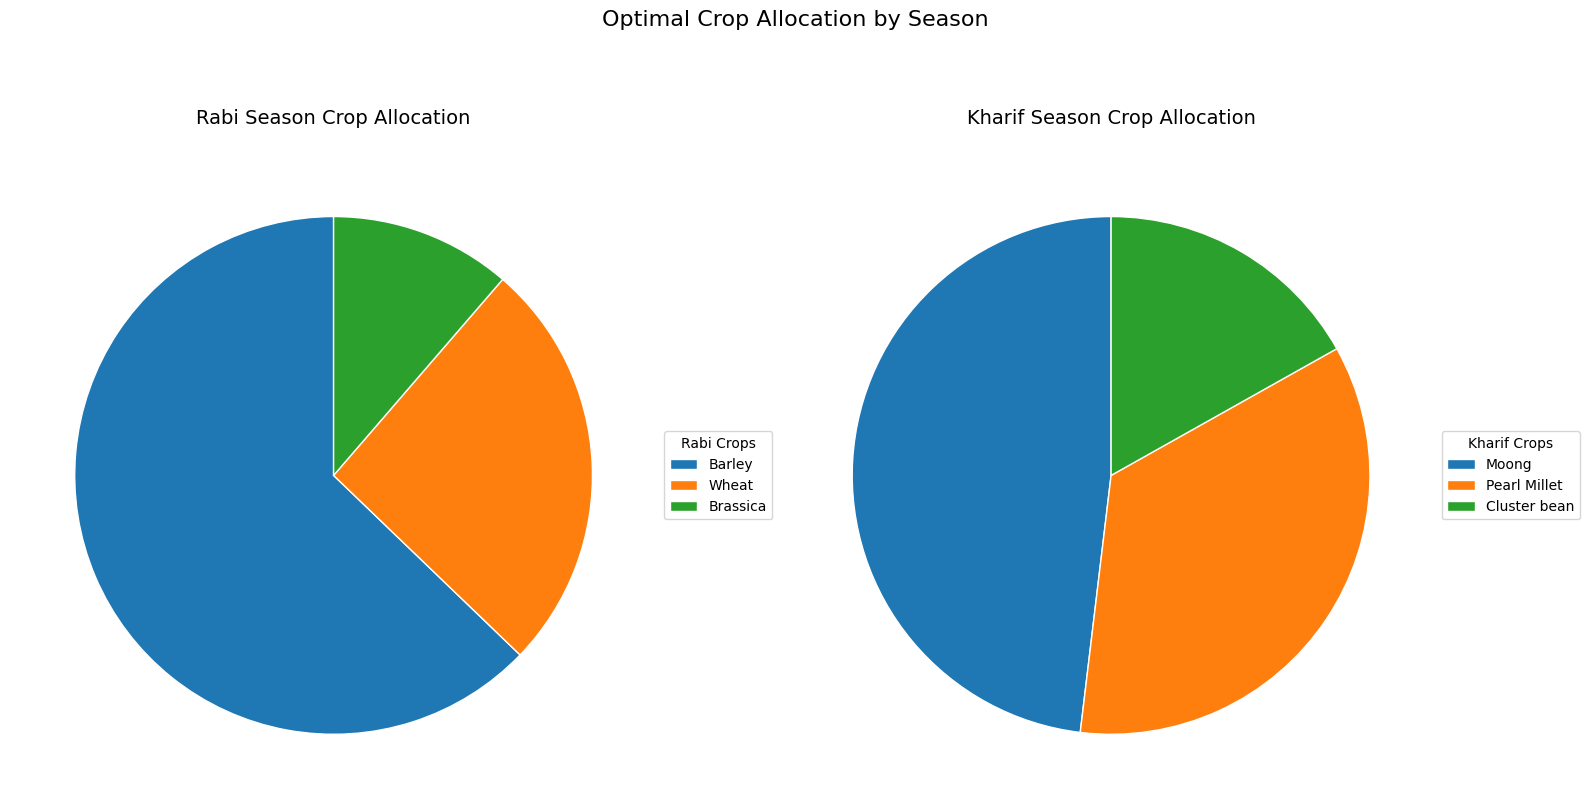

In [ ]:
def enhanced_plot_allocation(x):
    # Define crop name mappings
    crop_name_map = {
        'BajraY': 'Pearl Millet',
        'WheatY': 'Wheat',
        'MustardY': 'Brassica',
        'BarleyY': 'Barley',
        'GuarY': 'Cluster bean',
        'MoongY': 'Moong'
    }
    
    # Normalize the solution
    rabi_total = np.sum(x * rabi_mask)
    kharif_total = np.sum(x * kharif_mask)
    
    rabi_total = max(rabi_total, 1e-10)
    kharif_total = max(kharif_total, 1e-10)
    
    normalized = x.copy()
    normalized[rabi_mask == 1] = x[rabi_mask == 1] / rabi_total
    normalized[kharif_mask == 1] = x[kharif_mask == 1] / kharif_total
    
    # Prepare data with renamed crops
    rabi_data = [(crop_name_map[crop_yields[i]], normalized[i]) 
                for i in range(len(crop_yields)) if rabi_mask[i]]
    kharif_data = [(crop_name_map[crop_yields[i]], normalized[i]) 
                  for i in range(len(crop_yields)) if kharif_mask[i]]
    
    # Sort by allocation percentage
    rabi_data.sort(key=lambda x: x[1], reverse=True)
    kharif_data.sort(key=lambda x: x[1], reverse=True)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Rabi pie chart (no percentages)
    rabi_labels = [crop for crop, perc in rabi_data]
    rabi_sizes = [perc for crop, perc in rabi_data]
    rabi_colors = ['#1f77b4','#ff7f0e','#2ca02c']  # Blue, Orange, Green
    ax1.pie(rabi_sizes, colors=rabi_colors, startangle=90,
            wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
    ax1.set_title('Rabi Season Crop Allocation', pad=20, fontsize=14)
    
    # Kharif pie chart (no percentages)
    kharif_labels = [crop for crop, perc in kharif_data]
    kharif_sizes = [perc for crop, perc in kharif_data]
    kharif_colors = ['#1f77b4','#ff7f0e','#2ca02c']
    ax2.pie(kharif_sizes, colors=kharif_colors, startangle=90,
            wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
    ax2.set_title('Kharif Season Crop Allocation', pad=20, fontsize=14)
    
    # Add legends to the right
    ax1.legend(rabi_labels, title="Rabi Crops", 
               loc="center left", bbox_to_anchor=(1, 0.5))
    ax2.legend(kharif_labels, title="Kharif Crops", 
               loc="center left", bbox_to_anchor=(1, 0.5))
    
    # Add overall title
    plt.suptitle('Optimal Crop Allocation by Season', y=1.05, fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot enhanced visualization
enhanced_plot_allocation(best_x)

In [8]:
F= res_spea2.F
X = res_spea2.X

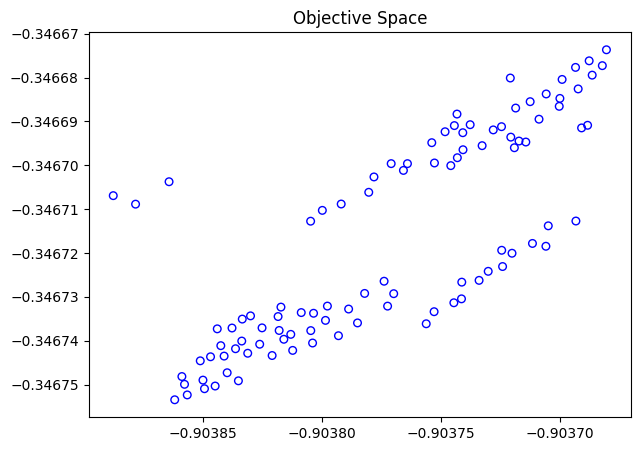

In [9]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

In [10]:
from pymoo.decomposition.asf import ASF
pareto_front = res_spea2.F
decomp = ASF()
weights = np.array([1, 1, 1])  # Equal weights for objectives
best_idx = np.argmin(decomp.do(pareto_front, weights))
print(f"Best solution index: {best_idx}")

Best solution index: 72


In [11]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
nds = NonDominatedSorting().do(pareto_front)
assert len(nds) == 1, "Pareto front contains dominated solutions!"

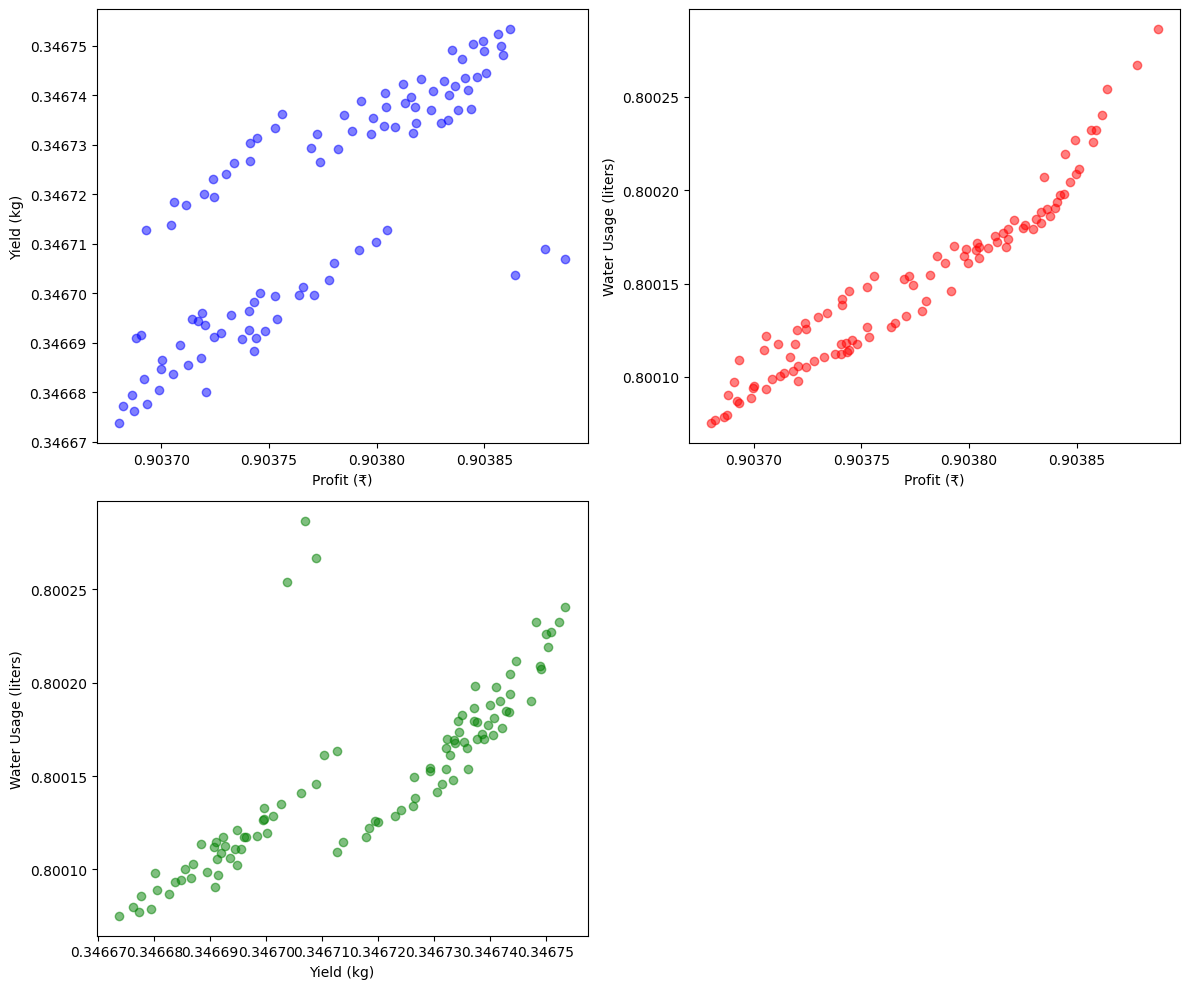

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.xlim(-0.4, -0.3)  
plt.ylim(-0.92, -0.90) 
# Profit vs. Yield
axes[0, 0].scatter(-F[:, 0], -F[:, 1], c='blue', alpha=0.5)  # Note: Negative if objectives were minimized
axes[0, 0].set_xlabel("Profit (₹)")
axes[0, 0].set_ylabel("Yield (kg)")

# Profit vs. Water
axes[0, 1].scatter(-F[:, 0], F[:, 2], c='red', alpha=0.5)
axes[0, 1].set_xlabel("Profit (₹)")
axes[0, 1].set_ylabel("Water Usage (liters)")

# Yield vs. Water
axes[1, 0].scatter(-F[:, 1], F[:, 2], c='green', alpha=0.5)
axes[1, 0].set_xlabel("Yield (kg)")
axes[1, 0].set_ylabel("Water Usage (liters)")

# Hide unused subplot
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

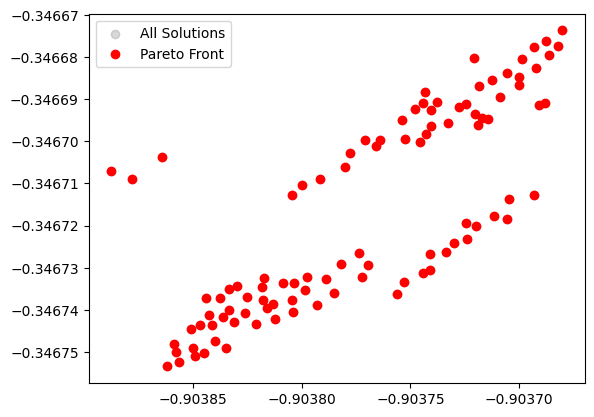

In [13]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

nds = NonDominatedSorting().do(F)
pareto_front = F[nds[0]]

plt.scatter(F[:, 0], F[:, 1], c='gray', alpha=0.3, label='All Solutions')
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], c='red', label='Pareto Front')
plt.legend()
plt.show()

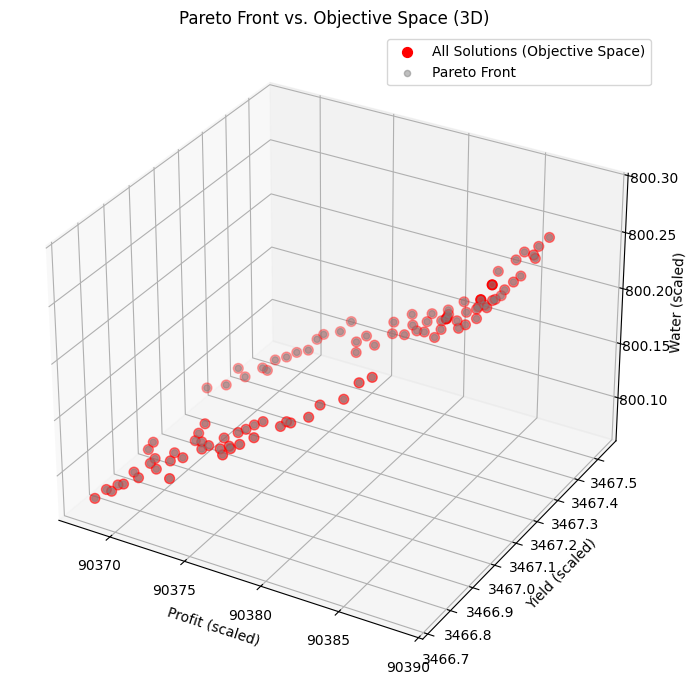

In [14]:
import matplotlib.pyplot as plt
from pymoo.visualization.scatter import Scatter

# Get the final population (includes dominated solutions)
final_pop = res_spea2.pop

# Extract objective values for all solutions in the population
all_F = np.array([ind.F for ind in final_pop])

# Pareto front (non-dominated solutions)
pareto_front = res_spea2.F

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot all solutions (objective space, gray)
ax.scatter(-all_F[:, 0]/problem.obj_scaling[0], -all_F[:, 1]/problem.obj_scaling[1], all_F[:, 2]/problem.obj_scaling[2], c='red', s=50, label="All Solutions (Objective Space)")

# Plot Pareto front (red)
ax.scatter(-pareto_front[:, 0]/problem.obj_scaling[0], -pareto_front[:, 1]/problem.obj_scaling[1], pareto_front[:, 2]/problem.obj_scaling[2], 
           c='grey', alpha=0.5, label="Pareto Front")

# Labels and title
ax.set_xlabel("Profit (scaled)")
ax.set_ylabel("Yield (scaled)")
ax.set_zlabel("Water (scaled)")
ax.set_title("Pareto Front vs. Objective Space (3D)")
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
hist = res_spea2.history
print(len(hist))

100


In [ ]:
n_evals = []             
hist_F = []            
hist_cv = []           
hist_cv_avg = []       

for algo in hist:
    n_evals.append(algo.evaluator.n_eval)
    opt = algo.opt
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])

At least one feasible solution in Generation 43 after 4400 evaluations.
Whole population feasible in Generation 54 after 5500 evaluations.


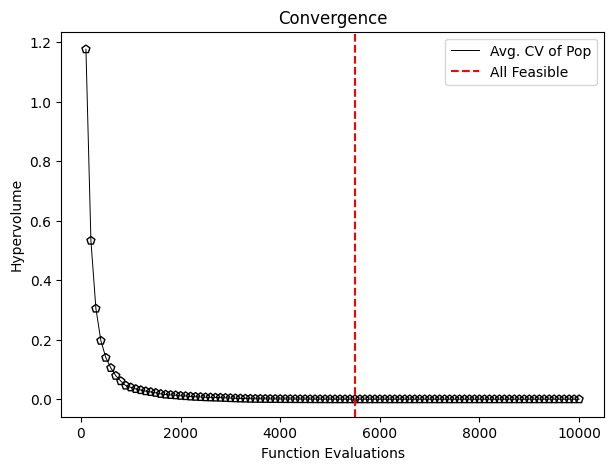

In [ ]:
k = np.where(np.array(hist_cv) <= 0.0)[0].min()
print(f"At least one feasible solution in Generation {k} after {n_evals[k]} evaluations.")
vals = hist_cv_avg
k = np.where(np.array(vals) <= 0.0)[0].min()
print(f"Whole population feasible in Generation {k} after {n_evals[k]} evaluations.")
plt.figure(figsize=(7, 5))
plt.plot(n_evals, vals,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, vals,  facecolor="none", edgecolor='black', marker="p")
plt.axvline(n_evals[k], color="red", label="All Feasible", linestyle="--")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.legend()
plt.show()

In [ ]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
front = NonDominatedSorting().do(res_spea2.F)[0]
pareto_solutions = res_spea2.F[front]
profit = -pareto_solutions[:, 0] / problem.obj_scaling[0]  # Note: Negative sign was used for maximization
yield_ = -pareto_solutions[:, 1] / problem.obj_scaling[1]
water = pareto_solutions[:, 2] / problem.obj_scaling[2]
pareto_allocations = res_spea2.X[front]

In [19]:
# Calculate total allocation per season for each solution
rabi_total = np.sum(pareto_allocations * rabi_mask, axis=1)
kharif_total = np.sum(pareto_allocations * kharif_mask, axis=1)

# Classify solutions (dominant season = higher allocation)
dominant_season = np.where(rabi_total > kharif_total, "Rabi", "Kharif")

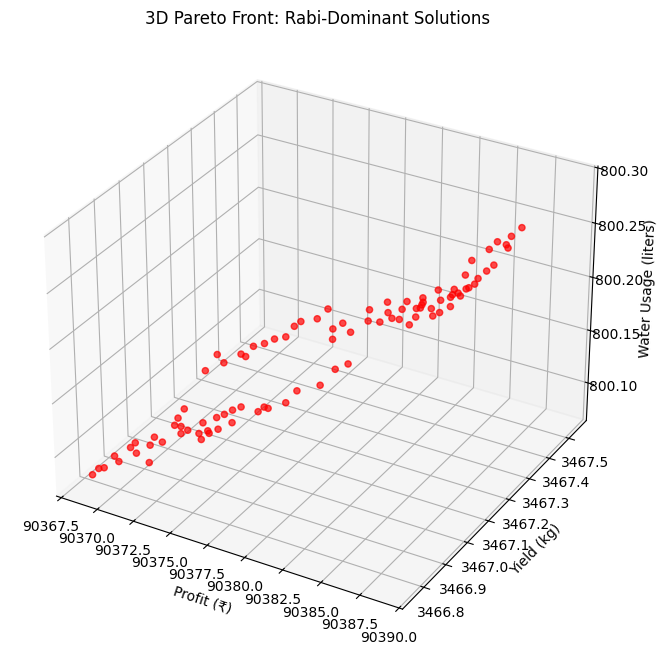

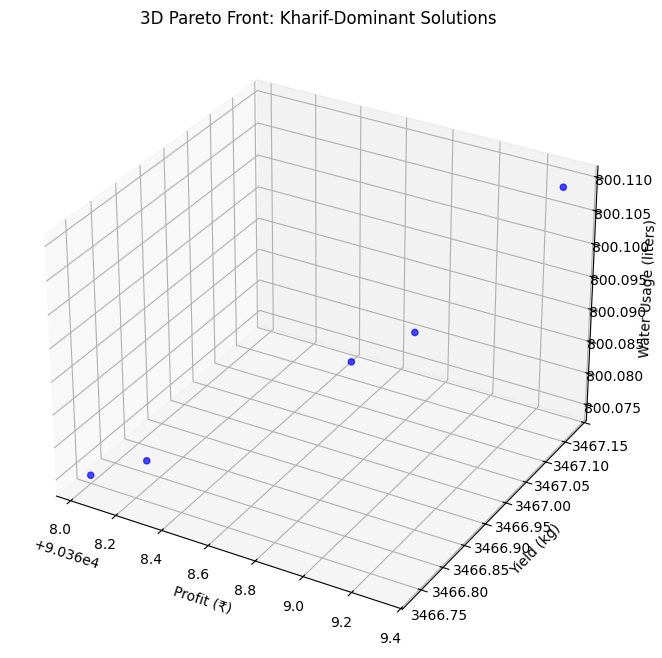

In [20]:
# Rabi-Dominant Solutions
rabi_mask = dominant_season == "Rabi"
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(profit[rabi_mask], yield_[rabi_mask], water[rabi_mask], c='red', alpha=0.7)
ax.set_xlabel("Profit (₹)"); ax.set_ylabel("Yield (kg)"); ax.set_zlabel("Water Usage (liters)")
ax.set_title("3D Pareto Front: Rabi-Dominant Solutions")
plt.show()

# Kharif-Dominant Solutions
kharif_mask = dominant_season == "Kharif"
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(profit[kharif_mask], yield_[kharif_mask], water[kharif_mask], c='blue', alpha=0.7)
ax.set_xlabel("Profit (₹)"); ax.set_ylabel("Yield (kg)"); ax.set_zlabel("Water Usage (liters)")
ax.set_title("3D Pareto Front: Kharif-Dominant Solutions")
plt.show()